#Importing libraries

In [ ]:
%%capture
!pip install mediapipe

In [ ]:
import numpy as np
import os,cv2,math,glob,random
import scipy.io as sio
from math import cos, sin
import mediapipe
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import cross_val_score,GridSearchCV
from google.colab.patches import cv2_imshow
from pathlib import Path
import pickle

In [ ]:
if os.path.isfile('/content/AFLW2000-3D.zip') == False:
  !gdown --id  1fP3zvSCYjll_o_m7S12nvQLZ9MnsEoap
  !unzip /content/AFLW2000-3D.zip

#Preparing the dataset 

In [ ]:
# X_points, Y_points, labels and detected files which are the images thar MediaPipe was able to detect the face  
X_points = []
Y_points = []
labels = []
detected_files = []

# extracting the file names (2000 name)
file_names = sorted([Path(f).stem for f in glob.glob("/content/AFLW2000/*.mat")])

# detecting faces and extracting the points
faceModule = mediapipe.solutions.face_mesh
# looping over the file names to load the images and their corresponding mat fil
for filename in file_names:
  with faceModule.FaceMesh(static_image_mode=True) as face_mesh:
    # loading the image
    image = cv2.imread('/content/AFLW2000/'+filename+'.jpg')
    # processing the image to detect the face and then generating the land marks (468 for each x,y,z).
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(rgb_image)
    if results.multi_face_landmarks != None: 
          # appending the file names where have been detected.
          detected_files.append(filename)
          # initializing two lists to store the points for the image.
          X = []
          Y = []
          height, width, _ = image.shape 
          # looping over the 468 points of x and y
          for pt1 in results.multi_face_landmarks[0].landmark:
              x = int(pt1.x * width)
              y = int(pt1.y * height)
              #cv2.circle(image, (x,y) , 1, (100,100,0), -1)
              # X_features
              X.append(x)
              # Y_features
              Y.append(y)
          # converting the lists to numpy arrays
          X = np.array(X)
          Y = np.array(Y)
          # appending the points of the images in the list of all image points
          X_points.append(X)
          Y_points.append(Y)

          # loading the mat file to extract the labels (pitch,yaw,roll)
          mat_file = sio.loadmat('/content/AFLW2000/'+filename+'.mat')
          # extracting the labels 3 angels
          pose_para = mat_file["Pose_Para"][0][:3]
          # appending the 3 angels to labels list
          labels.append(pose_para)

# converting features and labels to 2D array
X_points = np.array(X_points)
Y_points = np.array(Y_points)
labels = np.array(labels)

# the first label (pitch)
pitch_label = labels[:,0]
# the second label (yaw)
yaw_label = labels[:,1]
# the third label (roll)
roll_label = labels[:,2]

print(X_points.shape)
print(Y_points.shape)
print(labels.shape)

(1853, 468)
(1853, 468)
(1853, 3)


##Normalizing

In [ ]:
# center 99
# max = 10
# min = 171
# centering the data arround the 99th point 
Center_X = X_points - X_points[:,99].reshape(-1,1)
Center_Y = Y_points - Y_points[:,99].reshape(-1,1)

# normalizing the data to be in the same scale by dividing over the distance between point 10 and point 171
X_171 = X_points[:,171]
X_10 = X_points[:,10]
Y_171 = Y_points[:,171]
Y_10 = Y_points[:,10]

# computing the distance
distance = np.linalg.norm(np.array((X_10,Y_10)) - np.array((X_171,Y_171)),
                          axis = 0).reshape(-1,1)

Norm_X = Center_X / distance
Norm_Y = Center_Y / distance

# if you want to choose specific columns from the data
Final_X = Norm_X
Final_Y = Norm_Y

print(Final_X.shape)
print(Final_Y.shape)

# concatinating the X and Y points to form the compelete features
features = np.hstack([Final_X,Final_Y])
print(features.shape)

(1853, 468)
(1853, 468)
(1853, 936)


##Spliting the data

In [ ]:
# splitting the data
from sklearn.model_selection import train_test_split

features_train, X_val_test, labels_train, y_val_test = train_test_split(features,
                                                            labels,
                                                            test_size = 0.4,
                                                            random_state = 20)

features_validation, features_test, labels_validation, labels_test = train_test_split(X_val_test,
                                                                                      y_val_test,
                                                                                      test_size = 0.5,
                                                                                      random_state = 20)

file_train, file_test = train_test_split(detected_files , test_size = 0.2, random_state = 20)

y_train_pitch = labels_train[:,0]
y_train_yaw = labels_train[:,1]
y_train_roll = labels_train[:,2]
y_val_pitch = labels_validation[:,0]
y_val_yaw = labels_validation[:,1]
y_val_roll = labels_validation[:,2]

In [ ]:
print(len(features_train))
print(len(features_validation))
print(len(features_test))
print(len(labels_train))
print(len(labels_validation))
print(len(labels_test))

#Choosing and saving the model

In [ ]:
from sklearn.metrics import mean_absolute_error

In [ ]:

from sklearn.svm import SVR

svr_model_pitch = SVR().fit(features_train, y_train_pitch)
svr_model_yaw = SVR().fit(features_train, y_train_yaw)
svr_model_roll = SVR().fit(features_train, y_train_roll)

from sklearn.ensemble import RandomForestRegressor

rf_model_pitch = RandomForestRegressor().fit(features_train, y_train_pitch)
rf_model_yaw = RandomForestRegressor().fit(features_train, y_train_yaw)
rf_model_roll = RandomForestRegressor().fit(features_train, y_train_roll)

from xgboost import XGBRegressor

xg_model_pitch = XGBRegressor().fit(features_train, y_train_pitch)
xg_model_yaw = XGBRegressor().fit(features_train, y_train_yaw)
xg_model_roll = XGBRegressor().fit(features_train, y_train_roll)

[18:35:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
print("Scores of the models")
print("svr_model_pitch ", svr_model_pitch.score(features_validation, 
                                                y_val_pitch))
print("svr_model_yaw ", svr_model_yaw.score(features_validation, 
                                            y_val_yaw))
print("svr_model_roll ", svr_model_roll.score(features_validation, 
                                              y_val_roll))

Scores of the models
svr_model_pitch  0.48253049239677825
svr_model_yaw  0.9377534902445477
svr_model_roll  0.6857630980207199


In [ ]:
print("Scores of the models")
print("rf_model_pitch ", rf_model_pitch.score(features_validation, 
                                              y_val_pitch))
print("rf_model_yaw ", rf_model_yaw.score(features_validation, 
                                          y_val_yaw))
print("rf_model_roll ", rf_model_roll.score(features_validation, 
                                            y_val_roll))

Scores of the models
rf_model_pitch  -0.12557567262239044
rf_model_yaw  0.9103451511732779
rf_model_roll  -1.166684111375686


In [ ]:
print("Scores of the models")
print("xg_model_pitch ", xg_model_pitch.score(features_validation, 
                                              y_val_pitch))
print("xg_model_yaw ", xg_model_yaw.score(features_validation, 
                                          y_val_yaw))
print("xg_model_roll ", xg_model_roll.score(features_validation, 
                                            y_val_roll))

Scores of the models
xg_model_pitch  -4.925065318076381
xg_model_yaw  0.7437202196606995
xg_model_roll  -3.870026112838379


In [ ]:
param_grid  = [
               {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                'C': [0.01, 0.1, 1 , 10, 100],
                'gamma': [0.01, 0.1, 1, 10, 100]
                }]

# use gridsearch to find the best hyperparameters 
parameters_pitch = GridSearchCV(
    SVR(),
    param_grid,
    cv=5, 
    verbose=0
)
parameters_pitch.fit(features_train, y_train_pitch)
parameters_pitch.best_params_
pitch = parameters_pitch.best_estimator_

In [ ]:
param_grid  = [
               {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                'C': [0.01, 0.1, 1 , 10, 100],
                'gamma': [0.01, 0.1, 1, 10, 100]
                }]

# use gridsearch to find the best hyperparameters 
parameters_yaw = GridSearchCV(
    SVR(),
    param_grid,
    cv=5, 
    verbose=0
)
parameters_yaw.fit(features_train, y_train_yaw)
parameters_yaw.best_params_
yaw = parameters_yaw.best_estimator_

In [ ]:
param_grid  = [
               {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                'C': [0.01, 0.1, 1 , 10, 100],
                'gamma': [0.01, 0.1, 1, 10, 100]
                }]

# use gridsearch to find the best hyperparameters 
parameters_roll = GridSearchCV(
    SVR(),
    param_grid,
    cv=5, 
    verbose=0
)
parameters_roll.fit(features_train, y_train_roll)
parameters_roll.best_params_
roll = parameters_roll.best_estimator_

In [ ]:
filename = 'pitch_pred.sav'
pickle.dump(pitch, open(filename, 'wb'))

filename = 'yaw_pred.sav'
pickle.dump(yaw, open(filename, 'wb'))

filename = 'roll_pred.sav'
pickle.dump(roll, open(filename, 'wb'))


#Function for drawing

In [ ]:
def draw_axis(img, pitch,yaw,roll, tdx=None, tdy=None, size = 100):

    yaw = -yaw
    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v00
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)

    return img

#Sample from training dataset

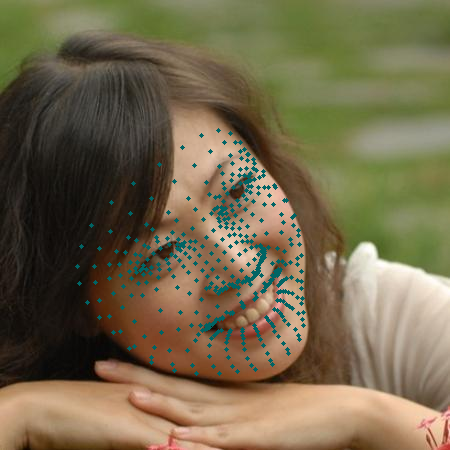

In [ ]:
# choosing random image from the testing data
image_name = random.choice(file_train)
faceModule = mediapipe.solutions.face_mesh

with faceModule.FaceMesh(static_image_mode=True) as face:
  
  image = cv2.imread('/content/AFLW2000/' + image_name + '.jpg')

  results = face.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

  if results.multi_face_landmarks != None:
    height, width, _ = image.shape 
    for pt1 in results.multi_face_landmarks[0].landmark:
              x = int(pt1.x * width)
              y = int(pt1.y * height)
              cv2.circle(image, (x,y) , 2, (100,100,0), -1)
  cv2_imshow(image)

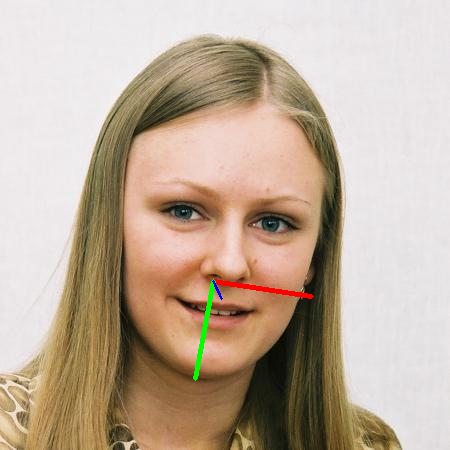

In [ ]:
frame = cv2.imread('/content/AFLW2000/' + image_name + '.jpg')
# reading the true labels and drawing the axis on the image
mat = sio.loadmat('/content/AFLW2000/' + image_name + '.mat')
pitch_true = mat["Pose_Para"][0][0]
yaw_true = mat["Pose_Para"][0][1]
roll_true = mat["Pose_Para"][0][2]
cv2_imshow(draw_axis(frame,pitch_true,yaw_true,roll_true,X[99],Y[99]))